<a href="https://colab.research.google.com/github/dhwan-dj/AIB16_Section1-project/blob/main/S1_PJT_AI_16_%EA%B9%80%EB%8F%99%ED%99%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.style.use("default")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
filename = '/content/drive/MyDrive/data/vgames2.csv'
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


- 데이터는 데이터프레임 자료형으로, (16598,10)의 shape, 연도를 제외한 거의 문자열 자료형이다.

In [95]:
df.head(10)

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
5,6,Power Pro Kun Pocket 8,DS,2005.0,Sports,Konami Digital Entertainment,0,0,0.14,0
6,7,JASF: Jane's Advanced Strike Fighters,PC,2011.0,Simulation,Deep Silver,0.02,0.01,0,0
7,8,Samurai Warriors: State of War,PSP,2005.0,Action,Tecmo Koei,0.07,0,0.11,0.01
8,9,Imabikisou,PS3,2007.0,Adventure,Sega,0,0,0.04,0
9,10,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011.0,Action,THQ,0.04,0.03,0,0.01


- 인덱스열이 있는데 순위를 가진 데이터는 아닌것 같고, 연도에 소수점이 보이고, 판매량은 float로 타입변경이 필요해보인다.
- 데이터파일 자체로 봤을때 판매량에 알파벳이 섞여있다.

In [96]:
df.duplicated().sum() #중복행 확인

0

In [97]:
df.isnull().sum() #결측열 확인

Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [98]:
df[df.isna().any(axis=1)] #결측행 확인

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
31,32,Rock Band,X360,NaN,Misc,Electronic Arts,1.93,0.34,0,0.21
50,51,Ape Escape: On the Loose,PSP,2005.0,NaN,Sony Computer Entertainment,0.52,0.01,0.12,0.05
109,110,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),Wii,NaN,Racing,Unknown,0,0,0.02,0
272,273,UK Truck Simulator,PC,2010.0,Simulation,NaN,0,0.03,0,0
273,274,Jewel Link Chronicles: Mountains of Madness,DS,NaN,Puzzle,Avanquest,0,0.06,0,0.01
...,...,...,...,...,...,...,...,...,...,...
16425,16426,Yoostar on MTV,X360,NaN,Misc,Unknown,0.06,0,0,0
16431,16432,Cars: Mater-National Championship,X360,2007.0,NaN,THQ,0.13,0,0,0.01
16432,16433,Bejeweled 3,X360,NaN,Puzzle,Unknown,0.13,0,0,0.01
16555,16556,Apache: Air Assault,PC,2010.0,NaN,Just Flight,0,0.03,0,0.01


In [99]:
# 정제단계 시행전 원본 DataFrame을 유지하기 위하여 카피
df_clean = df.copy()

In [100]:
# Publisher의 결측값은 분석결과에 큰 영향이 없을것이라 판단하고 Unknown 으로 바꿔줘야겠다. 먼저 개수 파악.
df_clean[df_clean.Publisher.isna()].shape

(58, 10)

In [101]:
df_clean.loc[:, ['Publisher']] = df_clean.loc[:, ['Publisher']].fillna('Unknown')

#채우고 나서 개수 파악.
df_clean.Publisher.isna().sum()

0

In [102]:
df_clean.isna().any() 

Unnamed: 0     False
Name           False
Platform       False
Year            True
Genre           True
Publisher      False
NA_Sales       False
EU_Sales       False
JP_Sales       False
Other_Sales    False
dtype: bool

In [103]:
# Year, Genre 결측행은 처리 방법이 마땅치 않으므로 drop해준다.
df_clean = df_clean.dropna().reset_index(drop=True)

# 다시 결측값 확인
df_clean.isna().any()

Unnamed: 0     False
Name           False
Platform       False
Year           False
Genre          False
Publisher      False
NA_Sales       False
EU_Sales       False
JP_Sales       False
Other_Sales    False
dtype: bool

In [104]:
# 'Unnamed: 0'열은 용도가 없으므로 삭제
df_clean = df_clean.drop(['Unnamed: 0'], axis=1)
df_clean

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...
16272,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16273,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16274,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16275,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [105]:
# Year 열의 소수점을 제거해준다.
df_clean = df_clean.astype({'Year':'int'})
df_clean # 소수 첫째자리는 그대로 표시됨.

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...
16272,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0,0.01
16273,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0,0,0
16274,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16275,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [106]:
# Sales 열에 문자와 섞여있는 행을 확인해본다.
import re

def chk_error(input):
  return bool(re.search('[a-zA-Z]', input))

error_NA = df_clean.NA_Sales.apply(chk_error)
error_na_sales = df_clean[error_NA]
error_na_sales

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
10,Ford Racing,PS,2001,Racing,Empire Interactive,480K,0.33M,0K,0.06
44,Resident Evil: Revelations 2,PS3,2015,Action,Capcom,60K,0.08,0.16,0.03
142,TOCA Race Driver 3,PC,2006,Racing,Codemasters,0K,0.02,0,0
440,Medal of Honor: Warfighter,X360,2012,Action,Electronic Arts,0.58M,0.47,0.01,0.1
451,F1 2010,PS3,2010,Racing,Codemasters,0.25M,0.76,0.08,0.27
...,...,...,...,...,...,...,...,...,...
16014,Midway Arcade Treasures,PS2,2003,Misc,Midway Games,720K,0.56,0,0.19
16092,NASCAR 06: Total Team Control,PS2,2005,Racing,Electronic Arts,0.53M,0.02,0,0.09
16163,Super Robot Taisen F Kanketsuhen,SAT,98,Strategy,Banpresto,0M,0,0.55,0
16173,Mortal Kombat,PSV,2012,Fighting,Warner Bros. Interactive Entertainment,470K,0.18,0,0.12


In [107]:
from sre_parse import SRE_FLAG_LOCALE
# 각 Sales 열의 숫자와 단위문자를 별도로 추출해 분석가능한 실수형으로 변환해주는 함수를 정의한다.
# 데이터를 봤을때 M이 붙은 숫자와 안붙은 숫자의 소수점이 비슷하다는 점에서 (Million, 백만) 단위로 추정
# 따라서 K(Kilo, 1000)의 경우, 0.001M로 변환하는 것이 타당하다고 판단

def convert(sales):
  if re.search(r'K',sales):     #판매량에 K 포함시
    num = sales[:-1]            #맨뒤 알파벳 제거
    num = float(num)
    scale = 0.001               #숫자에 0.001을 곱한다
    sales = num * scale
  elif re.search(r'M',sales):   #판매량에 M 포함시
    num = sales[:-1]            #맨뒤 알파벳 제거
    num = float(num)
    scale = 1                   #나머지 경우는 그대로 실수형으로 활용한다.
    sales = num * scale
  else:
    scale = 1
    num = sales
    num = float(num)
    sales = num * scale
  return sales

In [108]:
df_clean.NA_Sales = df_clean.NA_Sales.apply(str)
df_clean.EU_Sales = df_clean.EU_Sales.apply(str)
df_clean.JP_Sales = df_clean.JP_Sales.apply(str)
df_clean.Other_Sales = df_clean.Other_Sales.apply(str)

In [109]:
df_clean.NA_Sales = df_clean.NA_Sales.apply(convert)
df_clean.EU_Sales = df_clean.EU_Sales.apply(convert)
df_clean.JP_Sales = df_clean.JP_Sales.apply(convert)
df_clean.Other_Sales = df_clean.Other_Sales.apply(convert)

In [110]:
# 제대로 정제되었는지 의심되어 문자열로 다시 바꾼후 알파벳 포함되었는지 검사했다.
#df_clean.Other_Sales = df_clean.Other_Sales.apply(str)
#error = df_clean.Other_Sales.apply(chk_error)
#error_sales = df_clean[error]
#error_sales

- Year 열에 숫자 한, 두 자리만 있는 데이터들을 발견했다. 통계값으로 살펴봐야 하겠다.

In [111]:
# 품질 이슈 : Year의 이상치 확인 및 제거
df_clean.Year.describe()

count    16277.000000
mean      1994.206365
std        155.313461
min          0.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2020.000000
Name: Year, dtype: float64

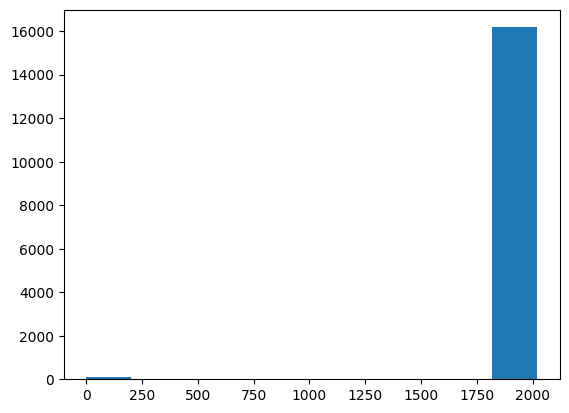

In [112]:
plt.hist(df_clean.Year);

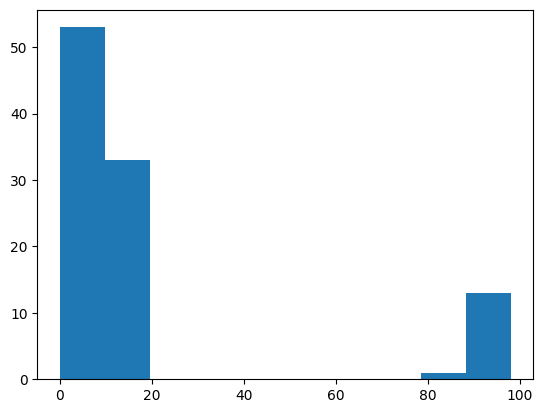

In [113]:
plt.hist(df_clean.Year[df_clean.Year<250]); # 이상치는 2가지로 2000년대와 1900년대로 나뉘어지는것 같다.

In [114]:
df_clean[df_clean.Year<250] #조사결과 20이하는 2000년대이고, 20초과는 1900년대이다.

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
72,Age of Empires III: Complete Collection,PC,9,Strategy,Microsoft Game Studios,0.01,0.12,0.00,0.03
79,Treasures of the Deep,PS,97,Action,Namco Bandai Games,0.10,0.07,0.00,0.01
210,NASCAR Unleashed,PS3,11,Racing,Activision,0.09,0.00,0.00,0.01
300,Kung Fu Panda: Showdown of Legendary Legends,PS3,15,Action,Little Orbit,0.00,0.02,0.00,0.00
759,NASCAR Thunder 2004,PS2,3,Racing,Electronic Arts,0.53,0.41,0.00,0.14
...,...,...,...,...,...,...,...,...,...
15676,Sugoi Hebereke,SNES,94,Fighting,Sunsoft,0.00,0.00,0.02,0.00
15792,Fab 5 Soccer,DS,8,Sports,Destineer,0.01,0.00,0.00,0.00
15837,Dragon Ball Z: Burst Limit,X360,8,Fighting,Atari,0.24,0.18,0.03,0.05
16078,Point Blank 3,PS,0,Shooter,Namco Bandai Games,0.01,0.01,0.00,0.00


In [115]:
df_clean.Year.unique()

array([2008, 2009, 2010, 2005, 2011, 2007, 2001, 2003, 2006, 2014, 2015,
       2002, 1997, 2013, 1996, 2004, 2000, 1984, 1998, 2016, 1985, 1999,
          9,   97, 1995, 1993, 2012, 1987, 1982,   11, 1994, 1990,   15,
       1992, 1991, 1983, 1988, 1981,    3, 1989,   96,    6,    8, 1986,
          1,    5,    4,   10,   98,    7,   16,   86,   14,   95, 2017,
       1980, 2020,    2,   13,    0,   12,   94])

In [116]:
# 연도 수정하는 함수 정의
def fix_Year(df):
  for i, year in enumerate(df.Year):
    if year < 20:
      df.loc[i, 'Year'] = df.loc[i, 'Year'] + 2000
    elif (year >= 20) & (year < 100):
      df.loc[i, 'Year'] = df.loc[i, 'Year'] + 1900
  
  return df

In [117]:
wrong_years = (df_clean.Year < 20) | (df_clean.Year >= 20) & (df_clean.Year < 100)
df_false_year = df_clean[wrong_years]
df_false_year

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
72,Age of Empires III: Complete Collection,PC,9,Strategy,Microsoft Game Studios,0.01,0.12,0.00,0.03
79,Treasures of the Deep,PS,97,Action,Namco Bandai Games,0.10,0.07,0.00,0.01
210,NASCAR Unleashed,PS3,11,Racing,Activision,0.09,0.00,0.00,0.01
300,Kung Fu Panda: Showdown of Legendary Legends,PS3,15,Action,Little Orbit,0.00,0.02,0.00,0.00
759,NASCAR Thunder 2004,PS2,3,Racing,Electronic Arts,0.53,0.41,0.00,0.14
...,...,...,...,...,...,...,...,...,...
15676,Sugoi Hebereke,SNES,94,Fighting,Sunsoft,0.00,0.00,0.02,0.00
15792,Fab 5 Soccer,DS,8,Sports,Destineer,0.01,0.00,0.00,0.00
15837,Dragon Ball Z: Burst Limit,X360,8,Fighting,Atari,0.24,0.18,0.03,0.05
16078,Point Blank 3,PS,0,Shooter,Namco Bandai Games,0.01,0.01,0.00,0.00


In [118]:
df_clean = fix_Year(df_clean)

In [119]:
wrong_years = (df_clean.Year < 20) | (df_clean.Year >= 20) & (df_clean.Year < 100)
df_false_year = df_clean[wrong_years]
df_false_year

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales


In [120]:
df_clean.Year.unique()

array([2008, 2009, 2010, 2005, 2011, 2007, 2001, 2003, 2006, 2014, 2015,
       2002, 1997, 2013, 1996, 2004, 2000, 1984, 1998, 2016, 1985, 1999,
       1995, 1993, 2012, 1987, 1982, 1994, 1990, 1992, 1991, 1983, 1988,
       1981, 1989, 1986, 2017, 1980, 2020])

In [121]:
# 품질 이슈 : Sales의 이상치 확인 및 제거
df_clean.NA_Sales.describe()

count    16277.000000
mean         0.264964
std          0.821587
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.490000
Name: NA_Sales, dtype: float64

- 최대값이 41인데도 평균이 0.2인건 0주변에 대다수의 데이터가 있음을 의미한다.
- 정규분포를 이루지 않는 데이터의 이상치제거를 위해 IQR방식 활용
- https://gannigoing.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B4%EC%83%81%EC%B9%98-outlier-%EC%9D%98-%EA%B8%B0%EC%A4%80%EC%9D%80-%EB%AC%B4%EC%97%87%EC%9D%BC%EA%B9%8C-f11f60bf901a
- https://hong-yp-ml-records.tistory.com/15

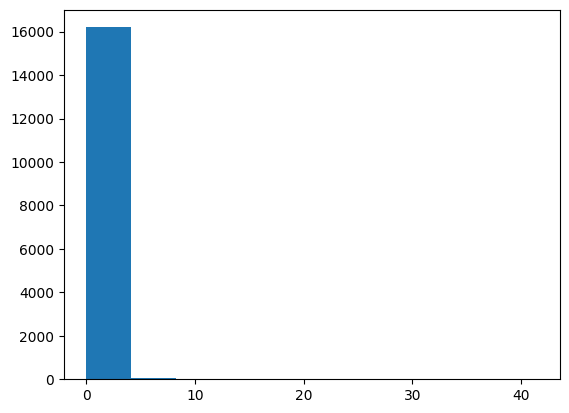

In [122]:
plt.hist(df_clean.NA_Sales);

In [123]:
def get_outlier(df=None, column=None):
  Q1 = np.percentile(df[column].values, 25)
  Q3 = np.percentile(df[column].values, 75)

  IQR = Q3 - Q1
  
  lowest = Q1 - IQR*1.5
  highest = Q3 + IQR*1.5
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [124]:
outlier_in_NA = get_outlier(df_clean, 'NA_Sales')
outlier_in_NA

Int64Index([   90,   105,   119,   123,   146,   152,   162,   179,   189,
              220,
            ...
            16196, 16212, 16219, 16225, 16226, 16227, 16233, 16253, 16263,
            16270],
           dtype='int64', length=1652)

In [125]:
outlier = df_clean.iloc[outlier_in_NA]

In [127]:
len(outlier), len(df_clean)

(1652, 16277)

- 판매량 3분위수(Q3)+IQR의 1.5배를 넘어가는 항목이 10%나 되기 때문에 이상치로 간주하기 힘들다.
- 한 지역만 있는 것이 아니라 4개의 지역이 있으므로 이상치가 데이터 개수의 5% 미만일때만 없애기로 한다.

In [129]:
less_10 = df_clean[df_clean.NA_Sales < 10]
larger_10 = df_clean[df_clean.NA_Sales >= 10]
len(less_10), len(larger_10)

(16264, 13)

In [130]:
df_clean[df_clean.NA_Sales >= 10] # 정말 이상치인지 확인해본다.

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1188,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58
2860,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46
2964,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85
3293,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96
4120,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77
4260,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67
6807,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90
7685,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00
9325,Super Mario Land,GB,1989,Platform,Nintendo,10.83,2.71,4.18,0.42
10299,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47


- 너무 유명한 누구나 알만한 레전드 게임들이라 이상치로 간주하지 않기로 한다.

In [131]:
# EU_Sales 이상치 확인 및 제거
df_clean.EU_Sales.describe()

count    16277.000000
mean         0.147202
std          0.507802
min          0.000000
25%          0.000000
50%          0.020000
75%          0.110000
max         29.020000
Name: EU_Sales, dtype: float64

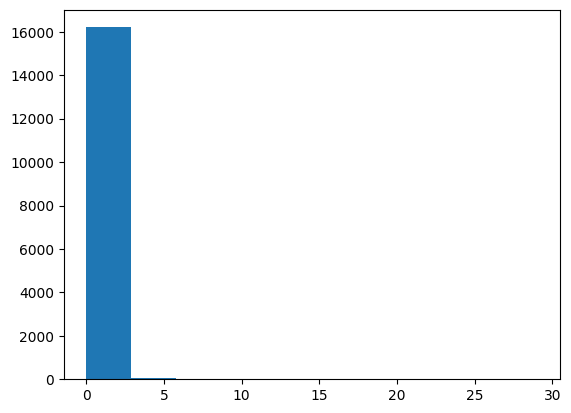

In [132]:
plt.hist(df_clean.EU_Sales);

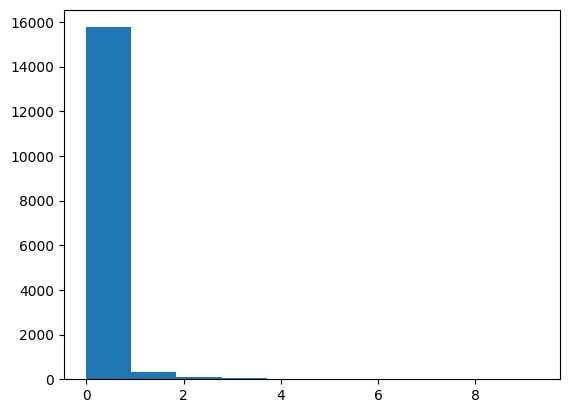

In [135]:
plt.hist(df_clean.EU_Sales[df_clean.EU_Sales<10]);

In [136]:
less_5 = df_clean[df_clean.EU_Sales < 5]
larger_5 = df_clean[df_clean.EU_Sales >= 5]
len(less_5), len(larger_5)

(16250, 27)

In [137]:
df_clean[df_clean.EU_Sales >= 5]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
504,Brain Age 2: More Training in Minutes a Day,DS,2005,Puzzle,Nintendo,3.44,5.36,5.32,1.18
993,Gran Turismo 3: A-Spec,PS2,2001,Racing,Sony Computer Entertainment,6.85,5.09,1.87,1.16
1978,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02
2592,FIFA 16,PS4,2015,Sports,Electronic Arts,1.11,6.06,0.06,1.26
2860,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46
2964,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85
3293,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96
3373,Wii Fit,Wii,2007,Sports,Nintendo,8.94,8.03,3.60,2.15
3420,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14
4159,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52


- 역시 유명한 메이져 타이틀들이므로 제거하지 않는다.

In [138]:
# JP_Sales 이상치 확인 및 제거
df_clean.JP_Sales.describe()

count    16277.000000
mean         0.078111
std          0.308951
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: JP_Sales, dtype: float64

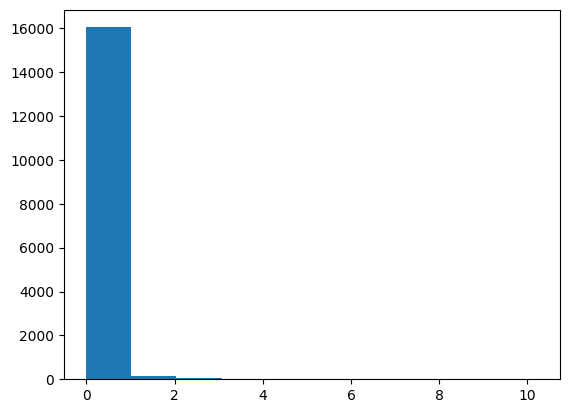

In [139]:
plt.hist(df_clean.JP_Sales);

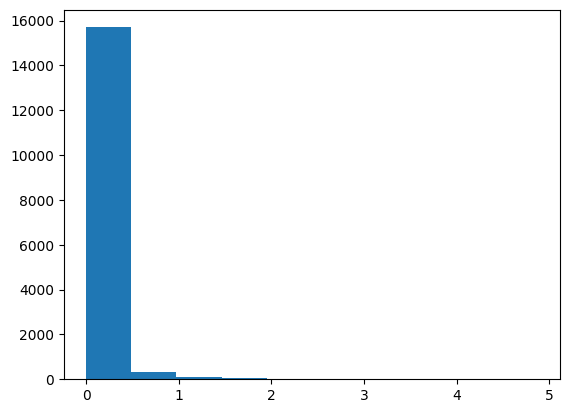

In [140]:
plt.hist(df_clean.JP_Sales[df_clean.JP_Sales<5]);

In [141]:
less_5 = df_clean[df_clean.JP_Sales < 5]
larger_5 = df_clean[df_clean.JP_Sales >= 5]
len(less_5), len(larger_5)

(16268, 9)

In [142]:
df_clean[df_clean.JP_Sales >= 5]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
504,Brain Age 2: More Training in Minutes a Day,DS,2005,Puzzle,Nintendo,3.44,5.36,5.32,1.18
3216,Animal Crossing: Wild World,DS,2005,Simulation,Nintendo,2.55,3.52,5.33,0.88
4120,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77
6807,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90
7685,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00
9251,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,Nintendo,9.00,6.18,7.20,0.71
10364,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,Nintendo,6.42,4.52,6.04,1.37
10429,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5.57,3.28,5.65,0.82
10717,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,Nintendo,6.06,3.90,5.38,0.50


- 일본에서 5 이상의 판매량을 거둔 최다 판매 타이틀들은 NES제외 휴대기기용인 것을 알 수 있다.
- https://www.google.com/search?q=NES&sourceid=chrome&ie=UTF-8

In [143]:
# Other_Sales 이상치 확인 및 제거
df_clean.Other_Sales.describe()

count    16277.000000
mean         0.048134
std          0.189480
min          0.000000
25%          0.000000
50%          0.010000
75%          0.040000
max         10.570000
Name: Other_Sales, dtype: float64

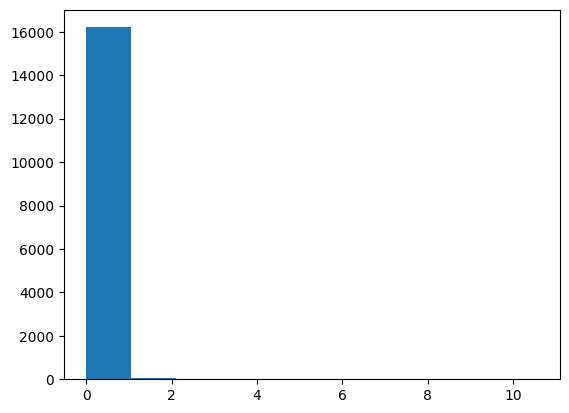

In [144]:
plt.hist(df_clean.Other_Sales);

In [147]:
less_3 = df_clean[df_clean.Other_Sales < 3]
larger_3 = df_clean[df_clean.Other_Sales >= 3]
len(less_3), len(larger_3)

(16272, 5)

In [148]:
df_clean[df_clean.Other_Sales >= 3]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
2860,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46
3420,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14
12341,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31
14383,Gran Turismo 4,PS2,2004,Racing,Sony Computer Entertainment,3.01,0.01,1.10,7.53
14387,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,9.43,0.40,0.41,10.57
